In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import networkx.algorithms.bipartite as bipartite
from multiprocessing import Pool
import random
import itertools
import pandas as pd
from collections import Counter
from joblib import Parallel, delayed
import sys
from collections import defaultdict
from scipy.special import factorial
import matplotlib as mpl
import single_instance
sys.path.append('lib/')
from degree_seq_bipartite import bipartite_degree_seq
import time
import pickle
from scipy.stats import pareto
def save_obj(obj, name ):
    with open('./Data/dic-'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open('./Data/dic-'+name+'.pkl', 'rb') as f:
        return pickle.load(f)
def flatten(seq):
  for el in seq:
    if isinstance(el, list):
      yield from flatten(el)
    else:
      yield el


module loaded at  2020-07-02 13:18:57.227811


Micorscopic cavity dynamics:
\begin{eqnarray}
v_i& \equiv \langle n_i\rangle =  1-\prod_{\mu \in\partial _i}\left(1-m_\mu^{(i)}\right)\\
m_\mu^{(i)}&\equiv\langle \tau_\mu^{(i)}\rangle = 1-\prod_{j\in\partial _\mu\setminus i}\left(1-p_{j\mu}v_j^{(\mu)}\right)\\
v_j^{(\mu)}& \equiv\langle n_j^{(\mu)}\rangle = 1-\prod_{\nu\in\partial _j\setminus \mu }\left(1-m_\nu^{(j)}\right)\\
\end{eqnarray}
In the following I label ``a`` the quantities that refers to individuals, ``b`` for the clusters

Generate structured networks

In [4]:
def _add_nodes_with_bipartite_label(G, lena, lenb):
    G.add_nodes_from(range(0,lena+lenb))
    b=dict(zip(range(0,lena),[0]*lena))
    b.update(dict(zip(range(lena,lena+lenb),[1]*lenb)))
    if nx.__version__>'2':
         nx.set_node_attributes(G,b,'bipartite')
    else:
         nx.set_node_attributes(G,'bipartite',b)
    return G

N_a = 50_000# n people
N_b = 50_000 #n clusters
f_n = [0.25,0.25,0.5] # fraction of people in group n
g_a = [0.4,0.5,0.1] # fraction of clusters in group a
def generate_structured_network(N_a,N_b,f_n,g_a):
    G = nx.empty_graph(0, default=nx.Graph)
    G = _add_nodes_with_bipartite_label(G, N_a, N_b)
    a_mean = 3. #average degree of the distribution
    #b_mean = (a_mean )* N_a / N_b 
    #aseq,bseq = bipartite_degree_seq(N_a*f_n[0],N_b*g_a[0],'shifted_poisson','shifted_poisson',{'lam':a_mean},{'lam':N_a*a_mean/N_b})
    G = nx.empty_graph(0, default=nx.Graph)
    G = _add_nodes_with_bipartite_label(G, N_a, N_b)
    a_stubs = range(int(N_a*f_n[0]))
    b_stubs = random.choices(np.arange(N_a,int(N_a+N_b*g_a[0])),k = int(N_a*f_n[0]))
    G.add_edges_from(zip(a_stubs,b_stubs))#n=0->a=0 

    aseq,bseq = bipartite_degree_seq(int(N_a*f_n[1]),int(N_b*g_a[0]),'poisson','poisson',{'lam':1},{'lam':5/8}) 
    a_stubs = itertools.chain.from_iterable([[i+int(N_a*f_n[0])]*k for i,k in enumerate(aseq) if k >0])
    b_stubs = list(itertools.chain.from_iterable([[mu+ N_a]*k for mu,k in enumerate(bseq) if k >0]))
    random.shuffle(b_stubs)
    G.add_edges_from(zip(a_stubs,b_stubs))#n=1->a=0

    aseq,bseq = bipartite_degree_seq(int(N_a*f_n[2]),int(N_b*g_a[0]),'shifted_poisson','poisson',{'lam':2},{'lam':5/2})#n=2->a=0 
    a_stubs = itertools.chain.from_iterable([[i+int(N_a*(f_n[1]+f_n[0]))]*k for i,k in enumerate(aseq) if k >0])
    b_stubs = list(itertools.chain.from_iterable([[mu+ N_a]*k for mu,k in enumerate(bseq) if k >0]))
    random.shuffle(b_stubs)
    _ = G.add_edges_from(zip(a_stubs,b_stubs))

    aseq,bseq = bipartite_degree_seq(int(N_a*f_n[1]),int(N_b*g_a[1]),'poisson','poisson',{'lam':1},{'lam':1/2})#n=1->a=1 
    a_stubs = itertools.chain.from_iterable([[i+int(N_a*f_n[0])]*k for i,k in enumerate(aseq) if k >0])
    b_stubs = list(itertools.chain.from_iterable([[mu+ N_a+int(N_b*g_a[0])]*k for mu,k in enumerate(bseq) if k >0]))
    random.shuffle(b_stubs)
    G.add_edges_from(zip(a_stubs,b_stubs))

    aseq,bseq = bipartite_degree_seq(int(N_a*f_n[2]),int(N_b*g_a[1]),'poisson','poisson',{'lam':1},{'lam':1})#n=2->a=1 
    a_stubs = itertools.chain.from_iterable([[i+int(N_a*(f_n[1]+f_n[0]))]*k for i,k in enumerate(aseq) if k >0])
    b_stubs = list(itertools.chain.from_iterable([[mu+ N_a+ int(N_b*g_a[0])]*k for mu,k in enumerate(bseq) if k >0]))
    random.shuffle(b_stubs)
    G.add_edges_from(zip(a_stubs,b_stubs))

    aseq,bseq = bipartite_degree_seq(int(N_a*f_n[2]),int(N_b*g_a[2]),'poisson','poisson',{'lam':1},{'lam':5})#n=2->a=2 
    a_stubs = itertools.chain.from_iterable([[i+int(N_a*(f_n[1]+f_n[0]))]*k for i,k in enumerate(aseq) if k >0])
    b_stubs = list(itertools.chain.from_iterable([[mu+ N_a+ int(N_b*(g_a[1]+g_a[0]))]*k for mu,k in enumerate(bseq) if k >0]))
    random.shuffle(b_stubs)
    _ = G.add_edges_from(zip(a_stubs,b_stubs))
    return G
G = generate_structured_network(N_a,N_b,f_n,g_a)

<built-in method poisson of numpy.random.mtrand.RandomState object at 0x7ff9d02c6af0>
<function shifted_poisson at 0x7ff9d3a9cef0>
<built-in method poisson of numpy.random.mtrand.RandomState object at 0x7ff9d02c6af0>
<built-in method poisson of numpy.random.mtrand.RandomState object at 0x7ff9d02c6af0>
<built-in method poisson of numpy.random.mtrand.RandomState object at 0x7ff9d02c6af0>


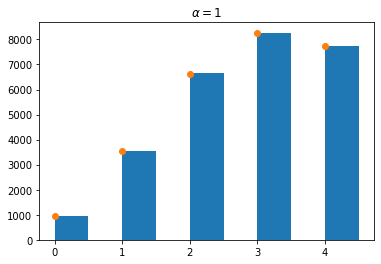

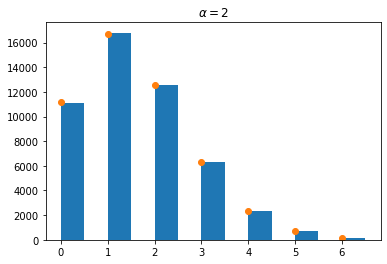

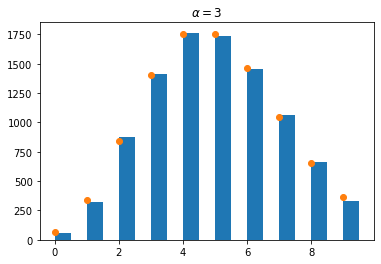

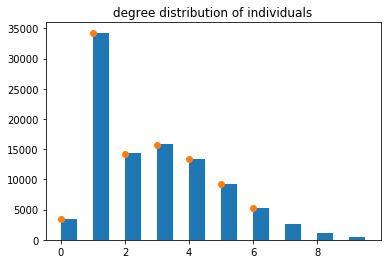

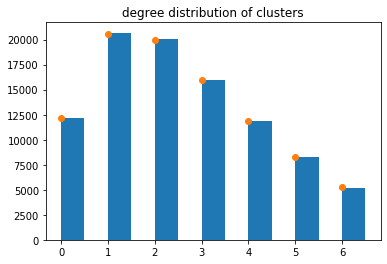

In [3]:
def plot_degree_structured(G):
    plt.hist(list(dict(G.degree(range(N_a,int(N_a+N_b*(g_a[0]))))).values()),bins = np.arange(0,5,0.5))
    k = np.arange(0,5,1)
    plt.plot(k,np.exp(-15/4)*(15/4)**k/factorial(k)*N_b*(g_a[0]),'o')#5/4*2+5/2
    plt.title('$\\alpha=1$')
    plt.figure()
    plt.hist(list(dict(G.degree(range(int(N_a+N_b*(g_a[0])),int(N_a+N_b*(g_a[1]+g_a[0]))))).values()),bins = np.arange(0,7,0.5))
    k = np.arange(0,7,1)
    plt.plot(k,np.exp(-3/2)*(3/2)**k/factorial(k)*N_b*(g_a[1]),'o')#1/2+1
    plt.title('$\\alpha=2$')
    plt.figure()
    plt.hist(list(dict(G.degree(range(int(N_a+N_b*(g_a[0]+g_a[1])),int(N_a+N_b*(g_a[1]+g_a[0]+g_a[2]))))).values()),bins = np.arange(0,10,0.5))
    k = np.arange(0,10,1)
    plt.plot(k,np.exp(-5)*(5)**k/factorial(k)*N_b*(g_a[2]),'o')#5/4*2+5/2
    plt.title('$\\alpha=3$')
    plt.figure()
    plt.hist(list(dict(G.degree(range(N_a))).values()),bins = np.arange(0,10,0.5))
    k = np.arange(0,7,1)
    plt.title('degree distribution of individuals')
    x = np.pad([0,N_a*(f_n[0])],(0,len(k)-2))+np.exp(-2)*(2)**k/factorial(k)*N_a*(f_n[1])+np.pad((np.exp(-3)*(3)**(k[:-1])/factorial(k[:-1]))*N_a*(f_n[2]),(1,0))
    plt.plot(k,x,'o')

    plt.figure()
    plt.hist(list(dict(G.degree(range(N_a,N_a+N_b))).values()),bins = np.arange(0,7,0.5))
    k = np.arange(0,7,1)
    plt.plot(k,np.exp(-3/2)*(3/2)**k/factorial(k)*N_b*(g_a[1])+np.exp(-5)*(5)**k/factorial(k)*N_b*(g_a[2])+np.exp(-15/4)*(15/4)**k/factorial(k)*N_b*(g_a[0]),'o')#1/2+1
    plt.title('degree distribution of clusters')
plot_degree_structured(G)

In [5]:
%%time
neigh = single_instance.Convert_typed(list(G.edges()))
states = single_instance.dict_to_typed_states(neigh)

CPU times: user 59.9 s, sys: 1.07 s, total: 1min
Wall time: 1min 1s


In [6]:
p = 0.3
%time risk = single_instance.single_instance_numba(neigh,states,N_a,N_b,p,N_iterations=100)

Exit after  7  iterations
CPU times: user 12.2 s, sys: 67.8 ms, total: 12.3 s
Wall time: 12.3 s


### Save single instance

In [26]:
risk = {key:value for key,value in risk.items()}
#neigh = {key:value for key,value in neigh.items()}
dic = {'p':p,'risk':risk,'N_a':N_a,'N_b':N_b}
#save_obj(dic,'structured_'+str(p))

### Load single instance

In [19]:
dic = load_obj('structured_0.3')
risk = dic['risk']
p = dic['p']

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


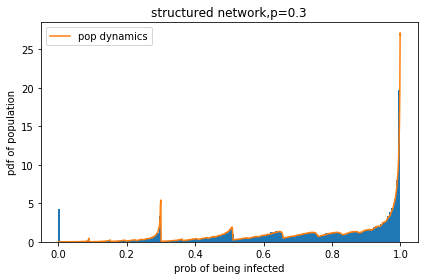

In [25]:
plt.hist(risk.values(),150,density=True)
plt.xlabel('prob of being infected')
plt.ylabel('pdf of population')
plt.title('structured network,p='+str(p))
df = pd.read_csv('./Data/SIRBStrPopDyn-P-tb03',sep = '   ',skiprows=1,usecols=[1,5],names =['v','prob'])
plt.plot(df.v,df.prob,label ='pop dynamics')
plt.legend()
plt.tight_layout()
#plt.savefig('structured_p=0.3.eps')


## Comparison  structured vs unstructured networks

In [7]:
N_samples = 200_000
A = generate_structured_network(N_samples,N_samples,f_n,g_a)
aseq= random.choices(list(zip(*list(A.degree(range(N_samples)))))[1],k = N_a)
bseq= random.choices(list(zip(*list(A.degree(range(N_samples,N_samples+N_samples)))))[1],k = N_b)
diff = sum(aseq)-sum(bseq)
count = 0
error = []
while diff!=0:
    n_new_samples = len(aseq) #int(abs(diff) /a_mean)
    new_samples = random.choices(list(zip(*list(G.degree(range(N_samples)))))[1],k = N_a)
    for proposed in new_samples:
        i = np.random.choice(len(aseq))
        k = aseq[i]
        count +=1
        error+=[(diff,count)]
        if abs(diff -k+ proposed )<abs(diff):
            aseq[i] = proposed
            diff = diff -k+ proposed
            if diff ==0:
                break
random.shuffle(bseq)
BG = bipartite.generators.configuration_model(aseq,bseq)
BG = nx.Graph(BG)#convert multilinks to simple 



<built-in method poisson of numpy.random.mtrand.RandomState object at 0x7fe00c1c9af0>
<function shifted_poisson at 0x7fe00f99ff80>
<built-in method poisson of numpy.random.mtrand.RandomState object at 0x7fe00c1c9af0>
<built-in method poisson of numpy.random.mtrand.RandomState object at 0x7fe00c1c9af0>
<built-in method poisson of numpy.random.mtrand.RandomState object at 0x7fe00c1c9af0>


performance of the degree sequence matching

Text(0.5, 0, 'iteration number')

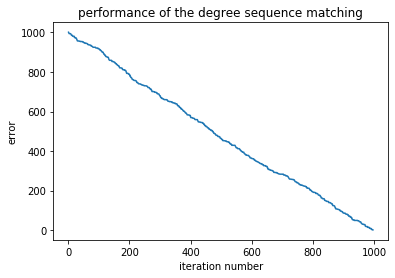

In [21]:
plt.plot(*list(zip(*error))[::-1])
plt.title('performance of the degree sequence matching')
plt.ylabel('error')
plt.xlabel('iteration number')

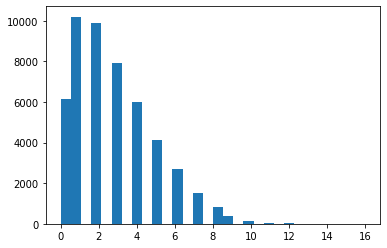

In [21]:
_ = plt.hist(dict(BG.degree(range(N_a,N_a+N_b))).values(),30)

In [8]:
%%time
neigh_unstr = single_instance.Convert_typed(list(BG.edges()))
states_unstr = single_instance.dict_to_typed_states(neigh_unstr)

CPU times: user 4min 26s, sys: 3.9 s, total: 4min 30s
Wall time: 4min 34s


In [9]:
p = 0.1
%time risk_unstr = single_instance.single_instance_numba(neigh_unstr,states_unstr,N_a,N_b,p,N_iterations=100)

Exit after  61  iterations
CPU times: user 2min 28s, sys: 1.65 s, total: 2min 29s
Wall time: 2min 33s


In [16]:
risk_unstr = {key:value for key,value in risk_unstr.items()}
#neigh = {key:value for key,value in neigh.items()}
dic = {'p':p,'risk':risk_unstr,'N_a':N_a,'N_b':N_b}
#save_obj(dic,'unstructured_'+str(p))

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


(0, 15)

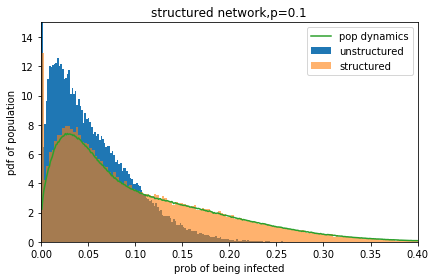

In [18]:
plt.hist(risk_unstr.values(),200,density=True,label ='unstructured')
plt.hist(risk.values(),200,density=True,label = 'structured',alpha = 0.6)
plt.xlabel('prob of being infected')
plt.ylabel('pdf of population')
plt.title('structured network,p='+str(p))
df = pd.read_csv('./Data/SIRBStrPopDyn-P-tb01',sep = '   ',skiprows=1,usecols=[1,5],names =['v','prob'])
plt.plot(df.v,df.prob,label ='pop dynamics')
plt.legend()
plt.tight_layout()
plt.xlim(0,0.4)
plt.ylim(0,15)
#plt.savefig('./Figures/comparison_p=0.1.pdf')


In [21]:
dic.keys()

dict_keys(['p', 'risk', 'N_a', 'N_b'])

In [57]:
d = defaultdict(list)#this dictionary has key = sum_couplings, value  = list of P. 
for key, degree in dict(G.degree(range(N_a))).items():
    if degree >0:
        d[degree].append(risk[key])


dict_keys([1, 5, 3, 2, 4, 7, 6, 8, 9, 10, 12, 11, 13])

(0, 5000)

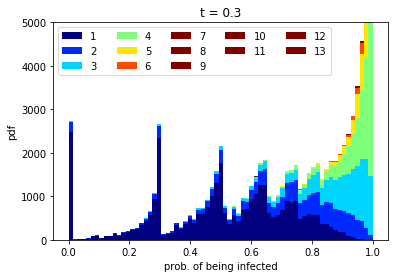

In [106]:
h_s = 0
#c_norm =mpl.colors.Normalize(vmin=min(d.keys()),vmax=max(d.keys()))
c_norm =mpl.colors.Normalize(vmin=min(d.keys()),vmax=7)
M = max(flatten(d.values()))

for k in sorted(d.keys(),key = np.abs):
    h,b,_=plt.hist(d[k],bottom = h_s,label = k,bins = np.linspace(0,M,70),color=plt.cm.jet(c_norm(k)))
    h_s+=h
plt.legend(ncol = 5)
plt.title('t = 0.3')
plt.xlabel('prob. of being infected')
plt.ylabel('pdf')
plt.ylim(0,5000)
#plt.savefig('degree_dependence2.pdf')


0.09

In [70]:
flatten

NameError: name 'flatten' is not defined